In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d.axes3d import get_test_data
from mpl_toolkits.mplot3d import Axes3D
from fenics import *
from mshr import *
import numpy as np
from dotenv import load_dotenv
from scipy.ndimage import zoom
from scipy.interpolate import interp1d
from scipy.stats import linregress
import os
import json
import glob


set_log_level(30)
# Cargar las variables del archivo .env
load_dotenv()

True

In [2]:
# Definir parámetros de tiempo desde el archivo .env
T = float(os.getenv('T'))
dt = float(os.getenv('dt'))
nb = int(os.getenv('nb'))
save_images = os.getenv('SAVE_IMAGES')

In [3]:

def obtener_archivos_corr_length(directorio, patron="corr_length_real_inverse_mean"):
    directorio = os.path.expanduser(directorio)

    if not os.path.exists(directorio):
        print(f"❌ Directorio no encontrado: {directorio}")
        return []

    # Buscar todos los .txt que contengan el patrón
    pattern = os.path.join(directorio, f"*{patron}*.txt")
    archivos = glob.glob(pattern)

    # Filtrar solo archivos (no carpetas)
    archivos = [archivo for archivo in archivos if os.path.isfile(archivo)]

    return archivos

In [4]:
def obtener_tipo_correlacion(file_path):
    """ Extrae el tipo de correlación del nombre del archivo """
    base_name = os.path.basename(file_path)
    partes = base_name.split("_")
    if len(partes) >= 4:
        return partes[-2] + "_" + partes[-1].split(".")[0]  # Extraer las últimas 3 letras
    return "Desconocido"

In [5]:
# Definir rutas de los directorios
ruta_strong_mu0 = '~/Drive/Doctorado Erick Serrato/25-I/strong_allee/mu_0'
ruta_strong_mu1 = '~/Drive/Doctorado Erick Serrato/25-I/strong_allee/mu_1'
ruta_weak_mu0 = '~/Drive/Doctorado Erick Serrato/25-I/weak_allee/mu_0'
ruta_weak_mu1 = '~/Drive/Doctorado Erick Serrato/25-I/weak_allee/mu_1'

In [6]:
# Lista de correlaciones
correlations = ["c_s", "c_i", "s_i", "c_c", "s_s", "i_i"]

# Rutas de los directorios (con ~ porque están en tu carpeta de Drive local)
rutas = {
    'strong_mu0': '~/Drive/Doctorado Erick Serrato/25-I/strong_allee/mu_0',
    'strong_mu1': '~/Drive/Doctorado Erick Serrato/25-I/strong_allee/mu_1',
    'weak_mu0':   '~/Drive/Doctorado Erick Serrato/25-I/weak_allee/mu_0',
    'weak_mu1':   '~/Drive/Doctorado Erick Serrato/25-I/weak_allee/mu_1',
}

for nombre_ruta, raw_path in rutas.items():
    path = os.path.expanduser(raw_path)
    print(f"\n📁 Procesando: {nombre_ruta} ({path})")

    for corr in correlations:
        # Buscar todos los archivos que coincidan con el patrón
        pattern = os.path.join(path, f"corr_length_real_inverse_nb*_{corr}.txt")
        matching_files = sorted(glob.glob(pattern))
        all_data = []
        file_shapes = []

        if not matching_files:
            print(f"  ❌ No se encontraron archivos para correlación: {corr}")
            continue

        for filename in matching_files:
            try:
                data = np.loadtxt(filename)

                if data.ndim == 1:
                    data = data.reshape(-1, 2)

                all_data.append(data)
                file_shapes.append((filename, data.shape))

            except Exception as e:
                print(f"  ⚠️  No se pudo leer {filename}: {e}")

        if all_data:
            ref_shape = all_data[0].shape
            archivos_filtrados = [d for d in all_data if d.shape == ref_shape]
            archivos_excluidos = [f for f, shape in file_shapes if shape != ref_shape]

            if archivos_excluidos:
                print(f"  ⚠️  Se excluyeron {len(archivos_excluidos)} archivos por forma desigual.")
                for excluido in archivos_excluidos:
                    print(f"     - {excluido}")

            if len(archivos_filtrados) >= 2:
                stacked = np.stack(archivos_filtrados, axis=0)
                mean_data = np.mean(stacked, axis=0)

                output_filename = os.path.join(path, f"corr_length_real_inverse_mean_{corr}.txt")
                np.savetxt(output_filename, mean_data)
                print(f"  ✅ Promedio guardado: {output_filename}")
            else:
                print(f"  ❌ No hay suficientes archivos con forma igual para {corr}")
        else:
            print(f"  ❌ No se pudieron cargar archivos válidos para: {corr}")



📁 Procesando: strong_mu0 (/home/erick/Drive/Doctorado Erick Serrato/25-I/strong_allee/mu_0)
  ✅ Promedio guardado: /home/erick/Drive/Doctorado Erick Serrato/25-I/strong_allee/mu_0/corr_length_real_inverse_mean_c_s.txt
  ✅ Promedio guardado: /home/erick/Drive/Doctorado Erick Serrato/25-I/strong_allee/mu_0/corr_length_real_inverse_mean_c_i.txt
  ✅ Promedio guardado: /home/erick/Drive/Doctorado Erick Serrato/25-I/strong_allee/mu_0/corr_length_real_inverse_mean_s_i.txt
  ✅ Promedio guardado: /home/erick/Drive/Doctorado Erick Serrato/25-I/strong_allee/mu_0/corr_length_real_inverse_mean_c_c.txt
  ✅ Promedio guardado: /home/erick/Drive/Doctorado Erick Serrato/25-I/strong_allee/mu_0/corr_length_real_inverse_mean_s_s.txt
  ✅ Promedio guardado: /home/erick/Drive/Doctorado Erick Serrato/25-I/strong_allee/mu_0/corr_length_real_inverse_mean_i_i.txt

📁 Procesando: strong_mu1 (/home/erick/Drive/Doctorado Erick Serrato/25-I/strong_allee/mu_1)
  ✅ Promedio guardado: /home/erick/Drive/Doctorado Erick S

In [7]:
def plot_correlation_loglog(title):
    resultados_regresion = {}

    files_to_plot = {
        "Strong μ=0": corr_length_strong_mu0,
        "Strong μ=1": corr_length_strong_mu1,
        "Weak μ=0": corr_length_weak_mu0,
        "Weak μ=1": corr_length_weak_mu1
    }

    for label, file_list in files_to_plot.items():
        if not file_list:
            print(f"🔍 {label}: lista vacía, se omite.")
            continue

        for file_path in file_list:
            plt.figure(figsize=(7, 6))
            try:
                data = np.loadtxt(file_path)

                if data.ndim == 1 or (data.ndim == 2 and data.shape[1] < 2):
                    print(f"⚠️ {file_path}: no tiene al menos dos columnas, se omite.")
                    continue

                # Asegurar que data tenga dos dimensiones
                if data.ndim == 1:
                    data = data.reshape(-1, 2)

                x, y = data[:, 0], data[:, 1]

                # Filtrar valores válidos
                valid_indices = (x > 0) & (y > 0) & np.isfinite(x) & np.isfinite(y)
                x, y = x[valid_indices], y[valid_indices]

                if len(x) <= 1:
                    print(f"{file_path}: No hay suficientes datos válidos para la regresión log-log.")
                    continue

                correlacion_tipo = obtener_tipo_correlacion(file_path)

                # Gráfico de puntos
                plt.loglog(x, y, marker='o', linestyle='-', label=label)

                # Ajuste log-log
                log_x = np.log(x)
                log_y = np.log(y)

                if np.all(np.isfinite(log_x)) and np.all(np.isfinite(log_y)):
                    slope, intercept, _, _, _ = linregress(log_x, log_y)

                    resultados_regresion[file_path] = {
                        "tipo_correlacion": correlacion_tipo,
                        "m": round(slope, 6),
                        "b": round(intercept, 6),
                        "funcion": f"g(r) ≈ e^{intercept:.6f} * r^{slope:.6f}"
                    }

                    fit_y = np.exp(intercept) * x ** slope
                    plt.loglog(x, fit_y, linestyle='--', label=f"Fit: g(r) ≈ e^{intercept:.4f} * t^{slope:.4f}")

                plt.xlabel("Distancia (r) [log]")
                plt.ylabel("g(r) [log]")
                plt.title(f"{title} - {correlacion_tipo} - Log-Log")
                plt.grid(True, which="both", linestyle='--', alpha=0.7)
                plt.legend()
                plt.tight_layout()
                plt.show()

            except Exception as e:
                print(f"❌ Error al cargar {file_path}: {e}")

    with open("resultados_regresion.json", "w") as file:
        json.dump(resultados_regresion, file, indent=4)

    return resultados_regresion

In [8]:
def plot_correlation_with_fit(selected_labels, title, fit_results_file="resultados_regresion.json"):
    # Cargar los resultados de la regresión desde el archivo JSON
    with open(fit_results_file, "r") as file:
        fit_results = json.load(file)
    
    # Diccionario de archivos disponibles para graficar
    available_files = {
        "Strong μ=0": corr_length_strong_mu0,
        "Strong μ=1": corr_length_strong_mu1,
        "Weak μ=0": corr_length_weak_mu0,
        "Weak μ=1": corr_length_weak_mu1
    }
    
    # Filtrar los archivos a graficar según la selección del usuario
    files_to_plot = [(label, available_files[label]) for label in selected_labels if label in available_files]
    
    # Determinar la cantidad de archivos a graficar (mínimo de todas las listas seleccionadas)
    num_plots = min(len(files) for _, files in files_to_plot)

    for i in range(num_plots):
        plt.figure(figsize=(10, 6))  # Tamaño de la figura
        
        for index, (label, file_list) in enumerate(files_to_plot):
            file_path = file_list[i]
            print(file_path)
            correlacion_tipo = obtener_tipo_correlacion(file_path)
            try:
                data = np.loadtxt(file_path)
                x, y = data[:, 0], data[:, 1]
                color = f"C{index}"  # Asignar color consistente por índice de archivo
                plt.plot(x, y, linestyle='dotted', color=color, label=f"{label} ({correlacion_tipo})")
                
                # Graficar la función de aproximación si está en los resultados
                if file_path in fit_results:
                    m = fit_results[file_path]["m"]
                    b = fit_results[file_path]["b"]
                    xi = 1 / m if m != 0 else np.inf  # Longitud de correlación ξ
                    fit_y = np.exp(b) * x ** m
                    plt.plot(x, fit_y, linestyle='--', color=color, 
                             label=f"Fit: ξ(t) ≈ e^{b:.6f} * t^{m:.6f}, ξ ≈ {xi:.6f}")
            except Exception as e:
                print(f"Error al cargar {file_path}: {e}")

        plt.xlabel("Distancia (r)", fontsize=12)  # Etiqueta del eje X
        plt.ylabel("g(r)", fontsize=12)  # Etiqueta del eje Y
        plt.title(f"{title} - {correlacion_tipo}", fontsize=14)  # Título de la gráfica con tipo de correlación
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)  # Añadir cuadrícula con líneas punteadas
        plt.tight_layout()  # Ajustar el diseño para evitar recortes
        plt.show()

In [21]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

def plot_fits_only(selected_labels, title, fit_results_file="resultados_regresion.json"):
    # Ruta de salida
    output_dir = os.path.expanduser("~/Drive/Doctorado Erick Serrato/25-I/weak_allee/")
    os.makedirs(output_dir, exist_ok=True)  # Crear el directorio si no existe

    # Cargar los resultados de la regresión desde el archivo JSON
    with open(fit_results_file, "r") as file:
        fit_results = json.load(file)
    
    # Diccionario de archivos disponibles para graficar
    available_files = {
        "Strong μ=0": corr_length_strong_mu0,
        "Strong μ=1": corr_length_strong_mu1,
        "Weak μ=0": corr_length_weak_mu0,
        "Weak μ=1": corr_length_weak_mu1
    }
    
    # Filtrar los archivos a graficar según la selección del usuario
    files_to_plot = [(label, available_files[label]) for label in selected_labels if label in available_files]
    
    # Determinar la cantidad de archivos a graficar (mínimo de todas las listas seleccionadas)
    num_plots = min(len(files) for _, files in files_to_plot)

    for i in range(num_plots):
        plt.figure(figsize=(10, 6))  # Tamaño de la figura

        correlacion_tipo = "Desconocido"
        
        for index, (label, file_list) in enumerate(files_to_plot):
            file_path = file_list[i]
            correlacion_tipo = obtener_tipo_correlacion(file_path)
            try:
                data = np.loadtxt(file_path)
                x = data[:, 0]
                color = f"C{index}"  # Asignar color consistente por índice de archivo

                # Graficar solo la función de aproximación si está en los resultados
                if file_path in fit_results:
                    m = 0.5
                    b = fit_results[file_path]["b"]
                    fit_y = np.exp(b) * x ** m
                    plt.plot(x, fit_y, linestyle='--', color=color, label=f"{label}  ξ(t) ≈ e^{b:.6f} * t^0.5")
            except Exception as e:
                print(f"Error al cargar {file_path}: {e}")

        plt.xlabel("Tiempo 't'", fontsize=12)
        plt.ylabel("ξ(t)", fontsize=12)
        plt.title(f"{title} - {correlacion_tipo}", fontsize=14)
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()

        output_filename = f"correlation_mean_{correlacion_tipo}.png"
        output_path = os.path.join(output_dir, output_filename)

        plt.savefig(output_path, dpi=300)
        print(f"Gráfica guardada en: {output_path}")
        plt.show()


In [12]:
# Obtener listas de archivos desde cada directorio
corr_length_strong_mu0 = obtener_archivos_corr_length(ruta_strong_mu0)
corr_length_strong_mu1 = obtener_archivos_corr_length(ruta_strong_mu1)
corr_length_weak_mu0 = obtener_archivos_corr_length(ruta_weak_mu0)
corr_length_weak_mu1 = obtener_archivos_corr_length(ruta_weak_mu1)

In [13]:
corr_length_strong_mu1

['/home/erick/Drive/Doctorado Erick Serrato/25-I/strong_allee/mu_1/corr_length_real_inverse_mean_c_c.txt',
 '/home/erick/Drive/Doctorado Erick Serrato/25-I/strong_allee/mu_1/corr_length_real_inverse_mean_c_i.txt',
 '/home/erick/Drive/Doctorado Erick Serrato/25-I/strong_allee/mu_1/corr_length_real_inverse_mean_c_s.txt',
 '/home/erick/Drive/Doctorado Erick Serrato/25-I/strong_allee/mu_1/corr_length_real_inverse_mean_i_i.txt',
 '/home/erick/Drive/Doctorado Erick Serrato/25-I/strong_allee/mu_1/corr_length_real_inverse_mean_s_i.txt',
 '/home/erick/Drive/Doctorado Erick Serrato/25-I/strong_allee/mu_1/corr_length_real_inverse_mean_s_s.txt']

In [ ]:
# Llamar a la función de graficación con las listas de archivos y un título
plot_correlation_loglog("Longitud de correlación")

In [ ]:
# # Ejemplo de uso: seleccionar qué conjuntos graficar
selected_labels = ["Weak μ=1", "Weak μ=0"]
#selected_labels = ["Strong μ=1", "Strong μ=0"]
plot_correlation_with_fit(selected_labels, "Longitud de correlación")

Gráfica guardada en: /home/erick/Drive/Doctorado Erick Serrato/25-I/weak_allee/correlation_mean_c_c.png


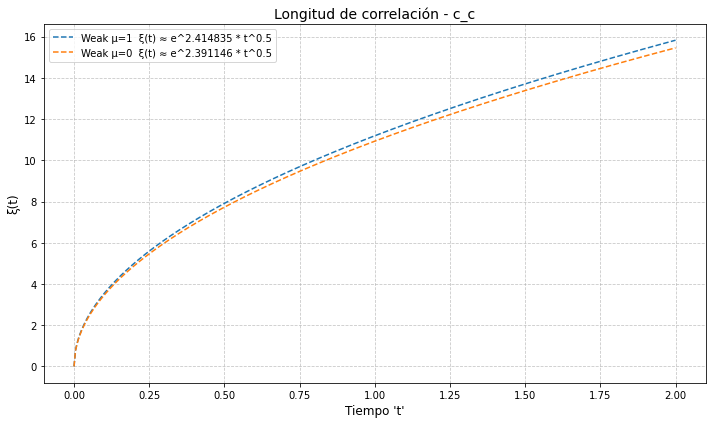

Gráfica guardada en: /home/erick/Drive/Doctorado Erick Serrato/25-I/weak_allee/correlation_mean_c_i.png


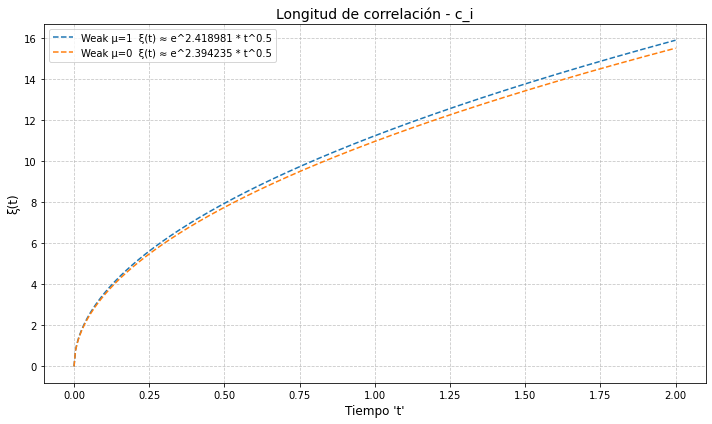

Gráfica guardada en: /home/erick/Drive/Doctorado Erick Serrato/25-I/weak_allee/correlation_mean_c_s.png


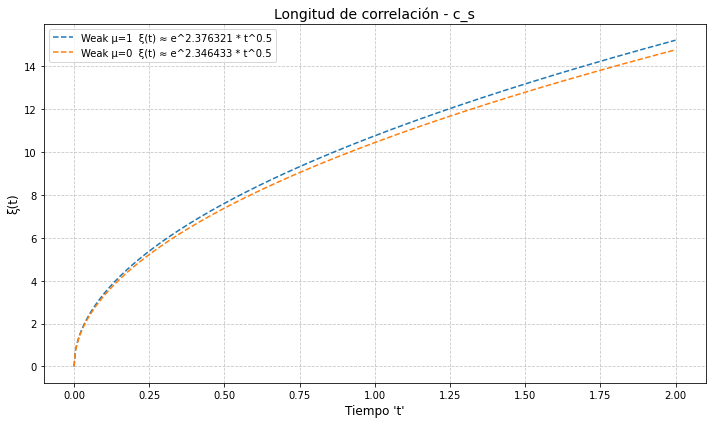

Gráfica guardada en: /home/erick/Drive/Doctorado Erick Serrato/25-I/weak_allee/correlation_mean_i_i.png


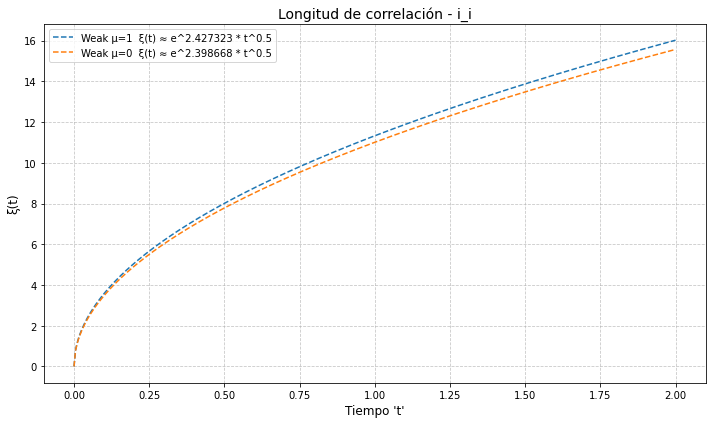

Gráfica guardada en: /home/erick/Drive/Doctorado Erick Serrato/25-I/weak_allee/correlation_mean_s_i.png


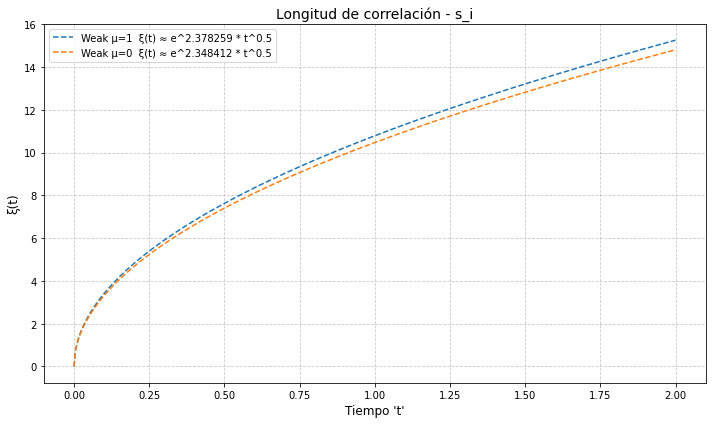

Gráfica guardada en: /home/erick/Drive/Doctorado Erick Serrato/25-I/weak_allee/correlation_mean_s_s.png


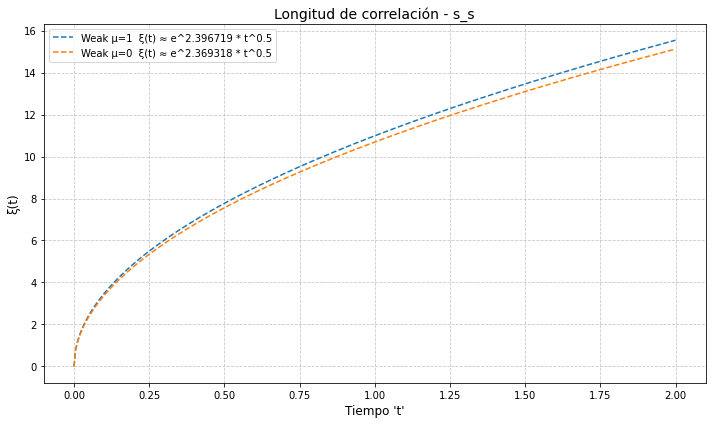

In [22]:
# selected_labels = ["Strong μ=0", "Weak μ=0", "Strong μ=1", "Weak μ=1"]
selected_labels = ["Weak μ=1", "Weak μ=0"]
plot_fits_only(selected_labels, "Longitud de correlación")

In [18]:
! ls

 cancer_dynamics.ipynb
 correlation_comparison.ipynb
 correlation_fourier.ipynb
'correlation_mean_['\''Weak μ=1'\'', '\''Weak μ=0'\''].png'
 correlation_real.ipynb
 correlation_results
 create_videos.ipynb
 estabilidad_lineal_weak_mu0.png
 estabilidad_lineal_weak_mu1.png
 fields_mu_0_weak.mp4
 fields_mu_1_weak.mp4
 main.ipynb
 requirements.txt
 resultados_regresion.json
 results_dirs.ipynb
 steady.nb
 steady_states.ipynb
 Untitled.ipynb
